In [1]:
import numpy as np
import sep

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array
file_path = "jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
data = fits.open(file_path)
data = data[1].data

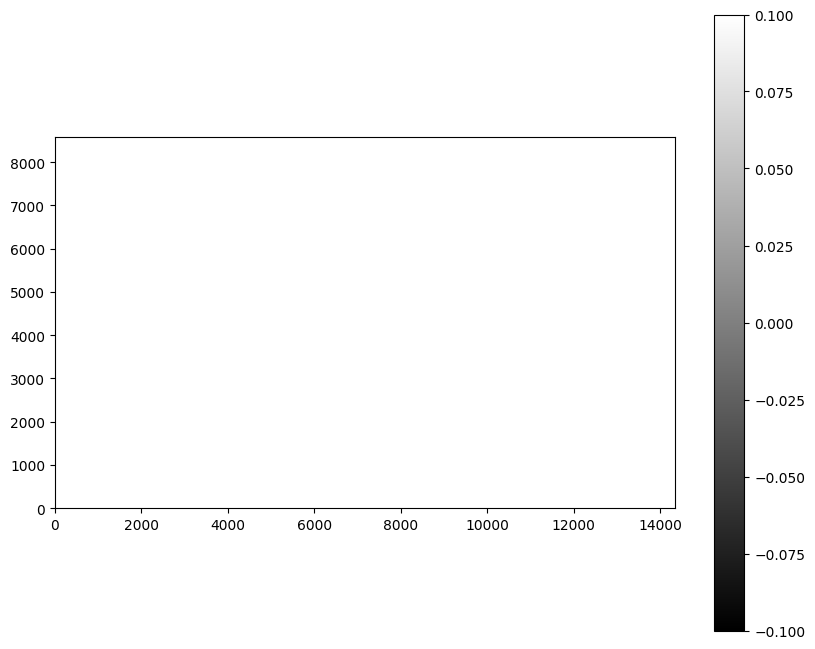

In [38]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [39]:
# measure a spatially varying background on the image
data = data.astype(data.dtype.newbyteorder('='))
bkg = sep.Background(data)

In [40]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1997147798538208
0.06582547724246979


In [41]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

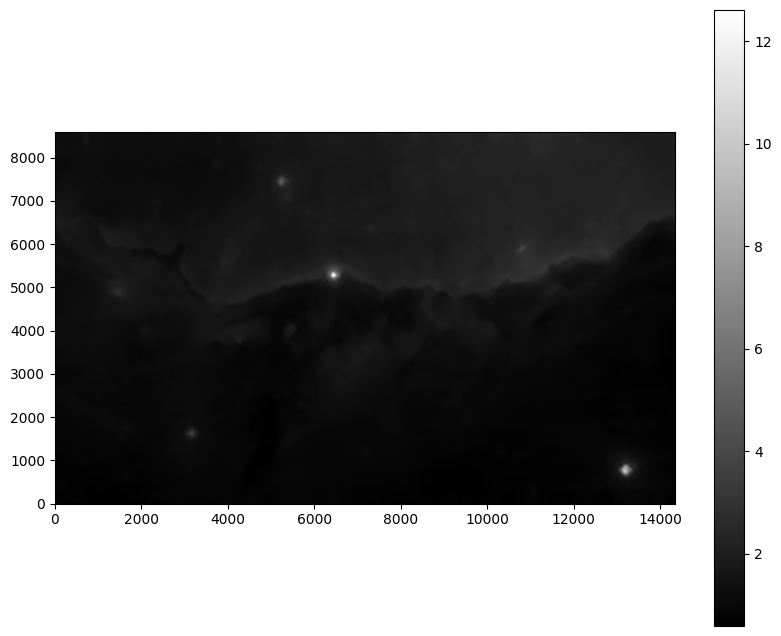

In [42]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [43]:
# evaluate the background noise as 2-d array, same size as original image# show the background noise
bkg_rms = bkg.rms()

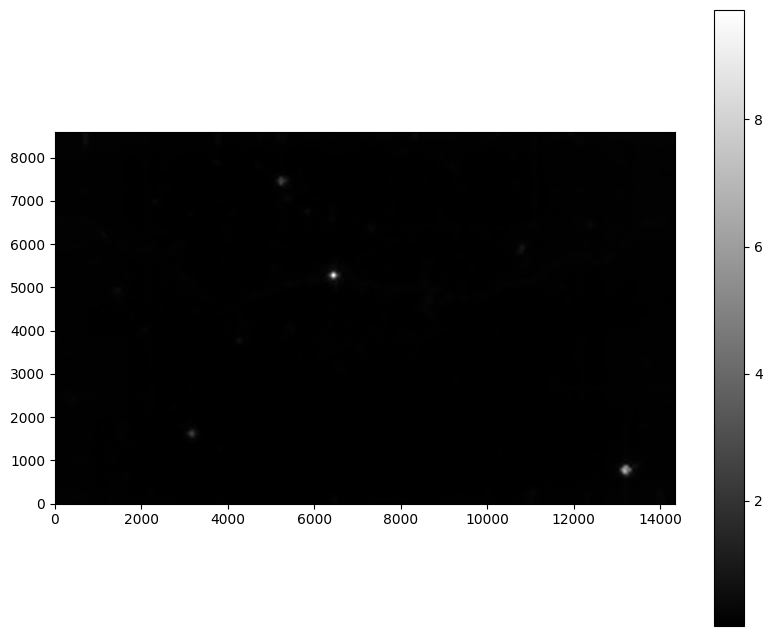

In [44]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [45]:
# subtract the background
data_sub = data - bkg

In [ ]:
sep.set_extract_pixstack(1000000)
objects = sep.extract(data_sub, 5.0, err=bkg.globalrms)

In [ ]:
print("Amount of Sources: ", len(objects))

In [ ]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [ ]:
# available fields
objects.dtype.names

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [ ]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

In [ ]:
plt.hist(flux,bins=30,edgecolor="black")
plt.xlabel('Flux')
plt.ylabel("Number of sources")
plt.title("Histogram of Fluxes")
plt.axvline(np.mean(flux),color='green',label=f'Mean = {np.mean(flux):.2f}')
plt.axvline(np.median(flux),color='red',label=f'Median = {np.median(flux):.2f}')
plt.legend()
plt.show()

mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

difference = np.abs(flux - mean_flux)
outlier_index = np.argmax(difference)
outlier_value = flux[outlier_index]
num_std_away = (outlier_value - mean_flux) / std_flux


In [ ]:
x_outlier = objects['x'][outlier_index]
y_outlier = objects['y'][outlier_index]
print(f"Outlier coordinates: x {x_outlier:.2f}, y = {y_outlier:.2f}")

In [ ]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = "jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = "jw02731-o001_t017_nircam_clear-f187n_i2d.fits"
fname2 = "jw02731-o001_t017_nircam_clear-f200w_i2d.fits"
fname3 = "jw02731-o001_t017_nircam_clear-f335m_i2d.fits"
fname4 = "jw02731-o001_t017_nircam_clear-f444w_i2d.fits"
fname5 = "jw02731-o001_t017_nircam_f444w-f470n_i2d.fits"

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

In [ ]:
data_f187n =  "jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits"
data_f200w =  "jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits"
data_f335m = "jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits"
data_f444w = "jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits"
data_f470n = "jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits"


data_2 = (fits.open(data_f187n))[0].data
data_3 = (fits.open(data_f200w))[0].data
data_4 = (fits.open(data_f335m))[0].data
data_5 = (fits.open(data_f444w))[0].data
data_6 = (fits.open(data_f470n))[0].data

def rescale_image(data,vmin=0.5,vmax=100):

    data_tmp = data.copy()

    m = np.nanmean(data_tmp)

    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    data_tmp = np.log10(data_tmp)
    return data_tmp

f = plt.figure(figsize=(5,5))

data = rescale_image(data) # blue
data_2 = rescale_image(data_2) # cyan
data_3 = rescale_image(data_3) # green
data_4 = rescale_image(data_4) # orange
data_5 = rescale_image(data_5) # red
data_6 = rescale_image(data_6) # yellow

data_all = np.zeros((data_2.shape[0],data_2.shape[1],3))

data = np.clip ( data + .1 * data_2,0,1)
data_2 = np.clip(data_4 + .1 * data_5,0,1)
data_3 = np.clip(data_3 + .1 * data_6,0,1)


data_all[:,:,0] = data
data_all[:,:,1] = data_2 
data_all[:,:,2] = data_3



data_all_res = rescale_image(data_all)

def remap(data):
    
    data_tmp = data.copy()

    dmin = data_tmp.min()
    dmax = data_tmp.max()
    return (data_tmp - dmin)/(dmax-dmin)

rgb_image = np.zeros((data_2.shape[0],data_2.shape[1],3))

rgb_image = remap(data_all_res)


f,ax = plt.subplots(1,1,figsize=(7,7))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("NGC 3324-JWST False Color")
plt.savefig("NGC3324_falsecolor.png",dpi=250,bbox_inches=None)
plt.show()